# T81-558: Applications of Deep Neural Networks
**Class 10: Recurrent and LSTM Networks**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Common Functions

Some of the common functions from previous classes that we will use again.

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the origional column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df,name,target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x)==str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name,tv)
        df[name2] = l
    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart, we will see more of this chart in the next class.
def chart_regression(pred,y):
    t = pd.DataFrame({'pred' : pred, 'y' : y_test.flatten()})
    t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Get a new directory to hold checkpoints from a neural network.  This allows the neural network to be
# loaded later.  If the erase param is set to true, the contents of the directory will be cleared.
def get_model_dir(name,erase):
    base_path = os.path.join(".","dnn")
    model_dir = os.path.join(base_path,name)
    os.makedirs(model_dir,exist_ok=True)
    if erase and len(model_dir)>4 and os.path.isdir(model_dir):
        shutil.rmtree(model_dir,ignore_errors=True) # be careful, this deletes everything below the specified path
    return model_dir

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name]-df[name].mean())>=(sd*df[name].std()))]
    df.drop(drop_rows,axis=0,inplace=True)
    
# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low =-1, normalized_high =1, 
                         data_low=None, data_high=None):
    
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])
    
    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
                * (normalized_high - normalized_low) + normalized_low

# Data Structure for Recurrent Neural Networks

Previously we trained neural networks with input ($x$) and expected output ($y$).  $X$ was a matrix, the rows were training examples and the columns were values to be predicted.  The definition of $x$ will be expanded and y will stay the same.

Dimensions of training set ($x$):
* Axis 1: Training set elements (sequences) (must be of the same size as $y$ size)
* Axis 2: Members of sequence
* Axis 3: Features in data (like input neurons)

Previously, we might take as input a single stock price, to predict if we should buy (1), sell (-1), or hold (0).

In [2]:
# 

x = [
    [32],
    [41],
    [39],
    [20],
    [15]
]

y = [
    1,
    -1,
    0,
    -1,
    1
]

print(x)
print(y)

[[32], [41], [39], [20], [15]]
[1, -1, 0, -1, 1]


This is essentially building a CSV file from scratch, to see it as a data frame, use the following:

In [3]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np

x = np.array(x)
print(x[:,0])


df = pd.DataFrame({'x':x[:,0], 'y':y})
display(df)

[32 41 39 20 15]


,x,y
0,32,1
1,41,-1
2,39,0
3,20,-1
4,15,1


You might want to put volume in with the stock price.  

In [4]:
x = [
    [32,1383],
    [41,2928],
    [39,8823],
    [20,1252],
    [15,1532]
]

y = [
    1,
    -1,
    0,
    -1,
    1
]

print(x)
print(y)

[[32, 1383], [41, 2928], [39, 8823], [20, 1252], [15, 1532]]
[1, -1, 0, -1, 1]


In [ ]:
Again, very similar to what we did before.  The following shows this as a data frame.

In [5]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np

x = np.array(x)
print(x[:,0])


df = pd.DataFrame({'price':x[:,0], 'volume':x[:,1], 'y':y})
display(df)

[32 41 39 20 15]


,price,volume,y
0,32,1383,1
1,41,2928,-1
2,39,8823,0
3,20,1252,-1
4,15,1532,1


Now we get to sequence format.  We want to predict something over a sequence, so the data format needs to add a dimension.  A maximum sequence length must be specified, but the individual sequences can be of any length.

In [6]:
x = [
    [[32,1383],[41,2928],[39,8823],[20,1252],[15,1532]],
    [[35,8272],[32,1383],[41,2928],[39,8823],[20,1252]],
    [[37,2738],[35,8272],[32,1383],[41,2928],[39,8823]],
    [[34,2845],[37,2738],[35,8272],[32,1383],[41,2928]],
    [[32,2345],[34,2845],[37,2738],[35,8272],[32,1383]],
]

y = [
    1,
    -1,
    0,
    -1,
    1
]

print(x)
print(y)

[[[32, 1383], [41, 2928], [39, 8823], [20, 1252], [15, 1532]], [[35, 8272], [32, 1383], [41, 2928], [39, 8823], [20, 1252]], [[37, 2738], [35, 8272], [32, 1383], [41, 2928], [39, 8823]], [[34, 2845], [37, 2738], [35, 8272], [32, 1383], [41, 2928]], [[32, 2345], [34, 2845], [37, 2738], [35, 8272], [32, 1383]]]
[1, -1, 0, -1, 1]


Even if there is only one feature (price), the 3rd dimension must be used:

In [7]:
x = [
    [[32],[41],[39],[20],[15]],
    [[35],[32],[41],[39],[20]],
    [[37],[35],[32],[41],[39]],
    [[34],[37],[35],[32],[41]],
    [[32],[34],[37],[35],[32]],
]

y = [
    1,
    -1,
    0,
    -1,
    1
]

print(x)
print(y)

[[[32], [41], [39], [20], [15]], [[35], [32], [41], [39], [20]], [[37], [35], [32], [41], [39]], [[34], [37], [35], [32], [41]], [[32], [34], [37], [35], [32]]]
[1, -1, 0, -1, 1]


# Recurrent Neural Networks

So far the neural networks that we’ve examined have always had forward connections.  The input layer always connects to the first hidden layer.  Each hidden layer always connects to the next hidden layer.  The final hidden layer always connects to the output layer.  This manner to connect layers is the reason that these networks are called “feedforward.”  Recurrent neural networks are not so rigid, as backward connections are also allowed. A recurrent connection links a neuron in a layer to either a previous layer or the neuron itself.  Most recurrent neural network architectures maintain state in the recurrent connections.  Feedforward neural networks don’t maintain any state.  A recurrent neural network’s state acts as a sort of short-term memory for the neural network.  Consequently, a recurrent neural network will not always produce the same output for a given input.

Recurrent neural networks do not force the connections to flow only from one layer to the next, from input layer to output layer.  A recurrent connection occurs when a connection is formed between a neuron and one of the following other types of neurons:

* The neuron itself
* A neuron on the same level
* A neuron on a previous level

Recurrent connections can never target the input neurons or the bias neurons.  
The processing of recurrent connections can be challenging. Because the recurrent links create endless loops, the neural network must have some way to know when to stop.  A neural network that entered an endless loop would not be useful.  To prevent endless loops, we can calculate the recurrent connections with the following three approaches:

* Context neurons
* Calculating output over a fixed number of iterations
* Calculating output until neuron output stabilizes

We refer to neural networks that use context neurons as a simple recurrent network (SRN).  The context neuron is a special neuron type that remembers its input and provides that input as its output the next time that we calculate the network.  For example, if we gave a context neuron 0.5 as input, it would output 0.  Context neurons always output 0 on their first call.  However, if we gave the context neuron a 0.6 as input, the output would be 0.5.  We never weight the input connections to a context neuron, but we can weight the output from a context neuron just like any other connection in a network.  

Context neurons allow us to calculate a neural network in a single feedforward pass.  Context neurons usually occur in layers.  A layer of context neurons will always have the same number of context neurons as neurons in its source layer, as demonstrated here:

![Context Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_context_layer.png "Context Layers")

As you can see from the above layer, two hidden neurons that are labeled hidden 1 and hidden 2 directly connect to the two context neurons.  The dashed lines on these connections indicate that these are not weighted connections. These weightless connections are never dense.  If these connections were dense, hidden 1 would be connected to both hidden 1 and hidden 2.  However, the direct connection simply joins each hidden neuron to its corresponding context neuron.  The two context neurons form dense, weighted connections to the two hidden neurons.  Finally, the two hidden neurons also form dense connections to the neurons in the next layer.  The two context neurons would form two connections to a single neuron in the next layer, four connections to two neurons, six connections to three neurons, and so on.

You can combine context neurons with the input, hidden, and output layers of a neural network in many different ways.  In the next two sections, we explore two common SRN architectures.

In 1990, Elman introduced a neural network that provides pattern recognition to time series.  This neural network type has one input neuron for each stream that you are using to predict.  There is one output neuron for each time slice you are trying to predict.  A single-hidden layer is positioned between the input and output layer.  A layer of context neurons takes its input from the hidden layer output and feeds back into the same hidden layer.  Consequently, the context layers always have the same number of neurons as the hidden layer, as demonstrated here:  

![Elman Neural Network](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_elman.png "Elman Neural Network")

The Elman neural network is a good general-purpose architecture for simple recurrent neural networks.  You can pair any reasonable number of input neurons to any number of output neurons.  Using normal weighted connections, the two context neurons are fully connected with the two hidden neurons.  The two context neurons receive their state from the two non-weighted connections (dashed lines) from each of the two hidden neurons.

Backpropagation through time works by unfolding the SRN to become a regular neural network.  To unfold the SRN, we construct a chain of neural networks equal to how far back in time we wish to go.  We start with a neural network that contains the inputs for the current time, known as t.  Next we replace the context with the entire neural network, up to the context neuron’s input.  We continue for the desired number of time slices and replace the final context neuron with a 0.  The following diagram shows an unfolded Elman neural network for two time slices.

![Unfolding the Elman Neural Network](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_elman_unfold.png "Unfolding the Elman Neural Network")

As you can see, there are inputs for both t (current time) and t-1 (one time slice in the past).  The bottom neural network stops at the hidden neurons because you don’t need everything beyond the hidden neurons to calculate the context input.  The bottom network structure becomes the context to the top network structure.  Of course, the bottom structure would have had a context as well that connects to its hidden neurons.  However, because the output neuron above does not contribute to the context, only the top network (current time) has one.


# Understanding LSTM

Some useful resources on LSTM/recurrent neural networks.

* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Recurrent Neural Networks in TensorFlow](https://www.tensorflow.org/versions/r0.11/tutorials/recurrent/index.html)

Long Short Term Neural Network (LSTM) are a type of recurrent unit that is often used with deep neural networks.  For TensorFlow, LSTM can be thought of as a layer type that can be combined with other layer types, such as dense.  LSTM makes use two transfer function types internally.  

The first type of transfer function is the sigmoid.  This transfer function type is used form gates inside of the unit.  The sigmoid transfer function is given by the following equation:

$$ \text{S}(t) = \frac{1}{1 + e^{-t}} $$

The second type of transfer function is the hyperbolic tangent (tanh) function.  This function is used to scale the output of the LSTM, similarly to how other transfer functions have been used in this course.  

The graphs for these functions are shown here:

Sigmoid


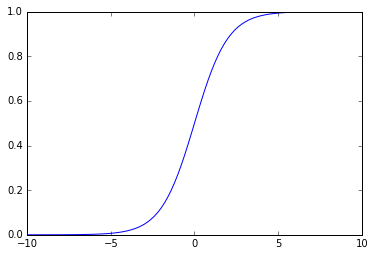

Hyperbolic Tangent(tanh)


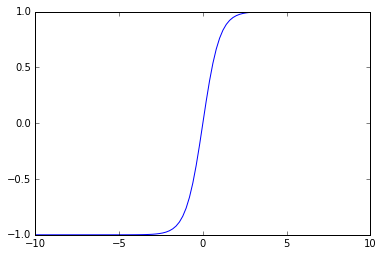

In [8]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

def f2(x):
    a = []
    for item in x:
        a.append(math.tanh(item))
    return a

x = np.arange(-10., 10., 0.2)
y1 = sigmoid(x)
y2 = f2(x)

print("Sigmoid")
plt.plot(x,y1)
plt.show()

print("Hyperbolic Tangent(tanh)")
plt.plot(x,y2)
plt.show()

Both of these two functions compress their output to a specific range.  For the sigmoid function, this range is 0 to 1.  For the hyperbolic tangent function, this range is -1 to 1.

LSTM maintains an internal state and produces an output.  The following diagram shows an LSTM unit over three time slices: the current time slice (t), as well as the previous (t-1) and next (t+1) slice:

![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm1.png "LSTM Layers")

The values $\hat{y}$ are the output from the unit, the values ($x$) are the input to the unit and the values $c$ are the context values.  Both the output and context values are always fed to the next time slice.  The context values allow 

![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm2.png "Inside the LSTM")

LSTM is made up of three gates:

* Forget Gate (f_t) - Controls if/when the context is forgotten. (MC)
* Input Gate (i_t) - Controls if/when a value should be remembered by the context. (M+/MS)
* Output Gate (o_t) - Controls if/when the remembered value is allowed to pass from the unit. (RM)

Mathematically, the above diagram can be thought of as the following:

**These are vector values.**

First, calculate the forget gate value.  This gate determines if the short term memory is forgotten.  The value $b$ is a bias, just like the bias neurons we saw before.  Except LSTM has a bias for every gate: $b_t$, $b_i$, and $b_o$.

$$ f_t = S(W_f \cdot [\hat{y}_{t-1}, x_t] + b_f) $$

Next, calculate the input gate value. This gate's value determines what will be remembered.

$$ i_t = S(W_i \cdot [\hat{y}_{t-1},x_t] + b_i) $$

Calculate a candidate context value (a value that might be remembered).  This value is called $\tilde{c}$.

$$ \tilde{C}_t = \tanh(W_C \cdot [\hat{y}_{t-1},x_t]+b_C) $$

Determine the new context ($C_t$).  Do this by remembering the candidate context ($i_t$), depending on input gate.  Forget depending on the forget gate ($f_t$). 

$$ C_t = f_t \cdot C_{t-1}+i_t \cdot \tilde{C}_t $$

Calculate the output gate ($o_t$):

$$ o_t = S(W_o \cdot [\hat{y}_{t-1},x_t] + b_o ) $$

Calculate the actual output ($\hat{y}_t$):

$$ \hat{y}_t = o_t \cdot \tanh(C_t) $$


# Simple TensorFlow LSTM Example

The following code creates the LSTM network.  This is an example of RNN classification.

In [2]:
import numpy as np
import pandas
import tensorflow as tf
from sklearn import metrics
#from tensorflow.models.rnn import rnn, rnn_cell
import tensorflow.contrib.learn as learn

SEQUENCE_SIZE = 6
HIDDEN_SIZE = 20
NUM_CLASSES = 4

def rnn_classify(X, y):
    y = tf.one_hot(y, NUM_CLASSES, 1, 0)
    inputs = tf.unpack(X, num=SEQUENCE_SIZE, axis=1)

    cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=HIDDEN_SIZE,state_is_tuple =False)
    _, encoding = tf.nn.rnn(
        cell=cell, inputs=inputs, dtype=tf.float32)

    logits = tf.contrib.layers.fully_connected(encoding, NUM_CLASSES, activation_fn=None)
    loss = tf.contrib.losses.softmax_cross_entropy(logits, y)

    train_op = tf.contrib.layers.optimize_loss(
        loss,
        tf.contrib.framework.get_global_step(),
        optimizer='Adam',
        learning_rate=0.01)

    return ({
                'class': tf.argmax(logits, 1),
                'prob': tf.nn.softmax(logits)
            }, loss, train_op)

# Get/clear a directory to store the neural network to
model_dir = get_model_dir('lstm_cls', True)

classifier = learn.Estimator(model_fn=rnn_classify, model_dir=model_dir)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'tf_random_seed': None, 'keep_checkpoint_every_n_hours': 10000, '_task_type': None, '_task_id': 0, '_environment': 'local', 'keep_checkpoint_max': 5, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'save_checkpoints_steps': None, '_is_chief': True, 'save_summary_steps': 100, 'save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002084D283F60>, '_num_ps_replicas': 0, '_master': '', '_evaluation_master': ''}


The following code trains on a data set (x) with a max sequence size of 6 (columns) and 6 training elements (rows)

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)
x = [
    [[0],[1],[1],[0],[0],[0]],
    [[0],[0],[0],[2],[2],[0]],
    [[0],[0],[0],[0],[3],[3]],
    [[0],[2],[2],[0],[0],[0]],
    [[0],[0],[3],[3],[0],[0]],
    [[0],[0],[0],[0],[1],[1]]
]
x = np.array(x,dtype=np.float32)
y = np.array([1,2,3,2,3,1],dtype=np.int32)

classifier.fit(x, y, steps=1000)


Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:loss = 1.41886, step = 1
INFO:tensorflow:Saving checkpoints for 1 into .\dnn\lstm1\model.ckpt.
INFO:tensorflow:loss = 0.00027103, step = 101
INFO:tensorflow:global_step/sec: 92.7614
INFO:tensorflow:loss = 0.000131754, step = 201
INFO:tensorflow:global_step/sec: 384.605
INFO:tensorflow:loss = 8.00648e-05, step = 301
INFO:tensorflow

Estimator(params=None)

In [36]:
tf.logging.set_verbosity(tf.logging.ERROR)
test = [[[0],[0],[0],[0],[3],[3]]]
test = np.array(test,dtype=np.float32)

pred = list(classifier.predict(test, as_iterable=True))
print(pred[0]['class'])

3


# Stock Market Example

An example of RNN regression.

In [5]:
# How to read data from the stock market.
from IPython.display import display, HTML
from pandas_datareader import data, wb
import datetime

start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2014, 12, 31)

# Get a quote for tsla from Yahoo service
f=data.DataReader('tsla', 'yahoo', start, end)
display(f)

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,149.800003,152.479996,146.550003,150.100006,6188400,150.100006
2014-01-03,150.000000,152.190002,148.600006,149.559998,4695000,149.559998
2014-01-06,150.000000,150.399994,145.240005,147.000000,5361100,147.000000
2014-01-07,147.619995,150.399994,145.250000,149.360001,5034100,149.360001
2014-01-08,148.850006,153.699997,148.759995,151.279999,6163200,151.279999
2014-01-09,152.500000,153.429993,146.850006,147.529999,5382000,147.529999
2014-01-10,148.460007,148.899994,142.250000,145.720001,7446100,145.720001
2014-01-13,145.779999,147.000000,137.820007,139.339996,6316100,139.339996
2014-01-14,140.500000,162.000000,136.669998,161.270004,27607000,161.270004


In [6]:
import numpy as np
prices = f.Close.pct_change().tolist() # to percent changes
prices = prices[1:] # skip the first, no percent change


SEQUENCE_SIZE = 5
x = []
y = []

for i in range(len(prices)-SEQUENCE_SIZE-1):
    #print(i)
    window = prices[i:(i+SEQUENCE_SIZE)]
    after_window = prices[i+SEQUENCE_SIZE]
    window = [[x] for x in window]
    #print("{} - {}".format(window,after_window))
    x.append(window)
    y.append(after_window)
    
x = np.array(x)
print(len(x))
    

245


In [13]:
def rnn_regression(X, y):
    #Fix issue fith float64 in tf
    X = tf.cast(X,tf.float32)
    #unpack is replaced by unstack in tf
    inputs = tf.unstack(X, num=SEQUENCE_SIZE, axis=1)
    #inputs = tf.unpack(X, num=SEQUENCE_SIZE, axis=1)

    cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=HIDDEN_SIZE,state_is_tuple =False)
    _, encoding = tf.nn.rnn(cell=cell, inputs=inputs, dtype=tf.float32)

    output = tf.contrib.layers.fully_connected(encoding, NUM_CLASSES, activation_fn=None)
    
    prediction, loss = tflearn.models.linear_regression(output, y)
    train_op = tf.contrib.layers.optimize_loss(
            loss, tf.contrib.framework.get_global_step(), optimizer=optimizer,
            learning_rate=learning_rate)
    return prediction, loss, train_op

# Get/clear a directory to store the neural network to
model_dir = get_model_dir('lstm_reg', True)

regressor = learn.Estimator(model_fn=rnn_regression, model_dir=model_dir)

regressor.fit(x, y)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'tf_random_seed': None, 'keep_checkpoint_every_n_hours': 10000, '_task_type': None, '_task_id': 0, '_environment': 'local', 'keep_checkpoint_max': 5, 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'save_checkpoints_steps': None, '_is_chief': True, 'save_summary_steps': 100, 'save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000208530C5278>, '_num_ps_replicas': 0, '_master': '', '_evaluation_master': ''}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and b

TypeError: Tensors in list passed to 'values' of 'Concat' Op have types [float64, float32] that don't all match.

In [17]:
# Try an in-sample prediction

from sklearn import metrics
# Measure RMSE error.  RMSE is common for regression.
pred = regressor.predict(x)
score = np.sqrt(metrics.mean_squared_error(pred,y))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.03126534778871552


In [19]:
# Try out of sample
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2015, 12, 31)

f=web.DataReader('tsla', 'yahoo', start, end)

import numpy as np
prices = f.Close.pct_change().tolist() # to percent changes
prices = prices[1:] # skip the first, no percent change


SEQUENCE_SIZE = 5
x = []
y = []

for i in range(len(prices)-SEQUENCE_SIZE-1):
    window = prices[i:(i+SEQUENCE_SIZE)]
    after_window = prices[i+SEQUENCE_SIZE]
    window = [[x] for x in window]
    x.append(window)
    y.append(after_window)
    
x = np.array(x)

# Measure RMSE error.  RMSE is common for regression.
pred = regressor.predict(x)
score = np.sqrt(metrics.mean_squared_error(pred,y))
print("Out of sample score (RMSE): {}".format(score))

Out of sample score (RMSE): 0.02485462016585515
